# 2) Exploratory Data Analysis

The Exploratory Data Analysis (EDA) is made of two parts:
- 1) A general overview of the number of stand up shows included in the study, their authors and producers;
- 2) An explorative analysis of the text data of all the stand-up shows NLP tecniques which will include:
    - Histograms of the distribution of words across documents;
    - Histograms of the distribution of sentences across documents;
    - Word clouds to study tokens and stopwords frequency.
    - Bar chart of the most common noun-chunks (i.e., noun plus close words related to it) present in the text.
    - Word clouds of lemmatized tokens which are tagged by the POS tagger as proper names, names or adjectives to further shed light on the content of the stand-up comedy scripts.

To perform the tasks mentioned in point 2), I will use the `SpaCy` language model. `SpaCy` is a powerful library that allows to perform many NLP tasks easily. It provides complete and flexible language processing pipelines to tokenize, part-of-speech (POS) tagging, dependency parsing, lemmatize texts as well as other tools that facilitate the exploration of text data.

## 2.1) General overview of the dataset

The EDA on the dataset of non-textual features provides some interesting insights on the characteristics of the stand-up comedy shows and their comedians:

- The first clear observation is that the vast majority of the shows have been produced by Netflix between 2015 and 2020. The time frame of the shows in itself could already suggest that popular topics at the center of the public debate in those years (e.g., terrorist attacks, American elections, Me Too movement) are likely to have been discussed in the shows.

- Most of the stand-up shows have English as original audio language. This is a confirmation of the fact that stand-up comedy is a phenomenon born and mostly diffused in English speaking countries. This could suggest that people, events and cultural references discussed in the shows are probably going to be related to English-speaking countries such as the US, UK, Australia, etc.

- The dataset is unbalanced on several dimensions. Comedians are predominantly male (77%) and there are also several comedians in the sample that produced more than one stand-up special. These elements might have an influence on both the topic modelling analysis and on the text generation.

In [9]:
# Imported libraries
from tqdm import tqdm
import os
import re
import string
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [10]:
# Open Stand_up_comedy dataset
df = pd.read_csv('Stand_up_comedy_dataset.csv')
print('Dataset shape:\n', df.shape)
df.info()
df.head(3)

Dataset shape:
 (143, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 11 columns):
Title                143 non-null object
Producer             143 non-null object
Comedian             143 non-null object
Gender               143 non-null object
Release date         143 non-null object
Original language    143 non-null object
Text                 143 non-null object
Len_Hours            143 non-null int64
Len_Minutes          143 non-null int64
Len_Seconds          143 non-null int64
File_name            143 non-null object
dtypes: int64(3), object(8)
memory usage: 12.4+ KB


,Title,Producer,Comedian,Gender,Release date,Original language,Text,Len_Hours,Len_Minutes,Len_Seconds,File_name
0,Adam DeVine: Best Time of Our Lives,Netflix,Adam DeVine,M,"June 18, 2019",English,"Hey, man. How are you? Thank you. Let's do thi...",0,57,44,Adam.Devine.Best.Time.of.Our.Lives.2019.720p.W...
1,Adam Sandler: 100% Fresh,Netflix,Adam Sandler,M,"October 23, 2018",English,"Okay, ready, and... Take your own cue, Adam. A...",1,13,38,Adam.Sandler.100.Percent.Fresh.2018.WEBRip.x26...
2,Adel Karam: Live From Beirut,Netflix,Adel Karam,M,"March 1, 2018",Arabic,A NETFLIX COMEDY SPECIAL CASINO LEBANON Hello....,0,57,23,Adel_Karam_Live_From_Beirut_En_en


In [11]:
# Create variable total runtime lenght in minutes
df['Len_total'] = (df['Len_Hours']*60)+df['Len_Minutes']+(df['Len_Seconds']/60)

# Apply correct datatype to relase date
df['Release date'] = pd.to_datetime(df['Release date'])
df['Release month'] = df['Release date'].dt.strftime('%B')
df['Release year'] = df['Release date'].dt.strftime('%Y')

df.head(3)

,Title,Producer,Comedian,Gender,Release date,Original language,Text,Len_Hours,Len_Minutes,Len_Seconds,File_name,Len_total,Release month,Release year
0,Adam DeVine: Best Time of Our Lives,Netflix,Adam DeVine,M,2019-06-18,English,"Hey, man. How are you? Thank you. Let's do thi...",0,57,44,Adam.Devine.Best.Time.of.Our.Lives.2019.720p.W...,57.733333,June,2019
1,Adam Sandler: 100% Fresh,Netflix,Adam Sandler,M,2018-10-23,English,"Okay, ready, and... Take your own cue, Adam. A...",1,13,38,Adam.Sandler.100.Percent.Fresh.2018.WEBRip.x26...,73.633333,October,2018
2,Adel Karam: Live From Beirut,Netflix,Adel Karam,M,2018-03-01,Arabic,A NETFLIX COMEDY SPECIAL CASINO LEBANON Hello....,0,57,23,Adel_Karam_Live_From_Beirut_En_en,57.383333,March,2018


#### Dashboard 1: Stand-up comedy shows

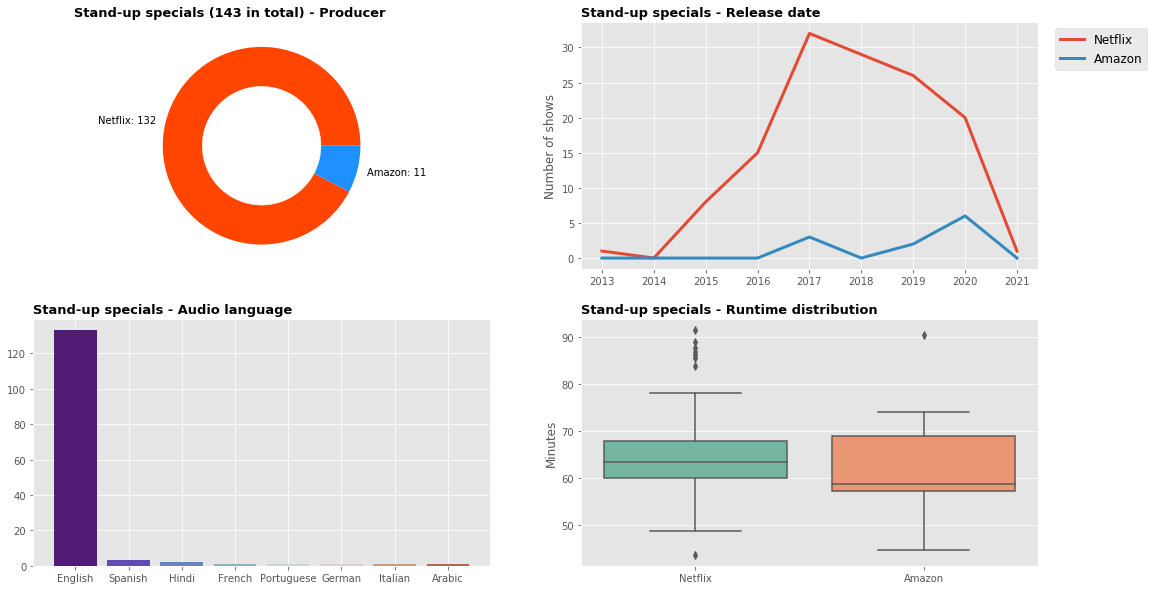

In [12]:
## General EDA charts panel (1) - Stand-up shows 

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 10 # set default font size

fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(18, 10))#set subplot and fig size

## AX1 - Producer

producer_num = list(df['Producer'].value_counts())
lbls = ['Netflix: {}'.format(producer_num[0]), 'Amazon: {}'.format(producer_num[1])]
colors = ['orangered', 'dodgerblue']

ax1.pie(producer_num, labels=['Netflix: {}'.format(producer_num[0]), 'Amazon: {}'.format(producer_num[1])], colors=colors)
ax1.add_artist(plt.Circle((0, 0), 0.6, color='white')) # white circle at the centre
ax1.set_title('Stand-up specials ({} in total) - Producer'.format(df.shape[0]), fontweight='bold', fontsize=13, loc='right')


## AX2- Original language

lang_num = list(df['Original language'].value_counts())
lang_lbl = list(df['Original language'].value_counts().index)

ax2.bar(lang_lbl, lang_num, color=sns.color_palette("twilight_shifted", 10))
ax2.tick_params(labelsize=10)
ax2.set_title('Stand-up specials - Audio language', fontweight='bold', fontsize=13, loc='left')


## AX3 - Number of shows overtime 

# Prepate lists for chart and fill with zero in years with NaN
years = range(2013, 2022)
netflix = list(df[df['Producer']=='Netflix'].groupby('Release year')['Title'].count())
netflix.insert(1, 0) 

amazon = list(df[df['Producer']=='Amazon'].groupby('Release year')['Title'].count())
amazon.insert(0, 0)
amazon.insert(0, 0)
amazon.insert(0, 0)
amazon.insert(0, 0)
amazon.insert(5, 0)
amazon.append(0)

# Plot
ax3.plot(years, netflix, linewidth=3.0, label='Netflix')
ax3.plot(years, amazon, linewidth=3.0, label='Amazon')
ax3.legend(bbox_to_anchor=(1.025, 1), loc='upper left', fontsize=12)
ax3.set_ylabel('Number of shows')
ax3.set_title('Stand-up specials - Release date', fontweight='bold', fontsize=13, loc='left')


## AX4 - Boxplot runtime by producer

ax4 = sns.boxplot(x=df['Producer'], y=df['Len_total'], palette="Set2", order=['Netflix', 'Amazon'], color=colors)
ax4.set_ylabel('Minutes')
ax4.set_xlabel('')
ax4.set_title('Stand-up specials - Runtime distribution', fontweight='bold', fontsize=13, loc='left')

plt.show()

#### Dashboard 2: Stand-up comedians

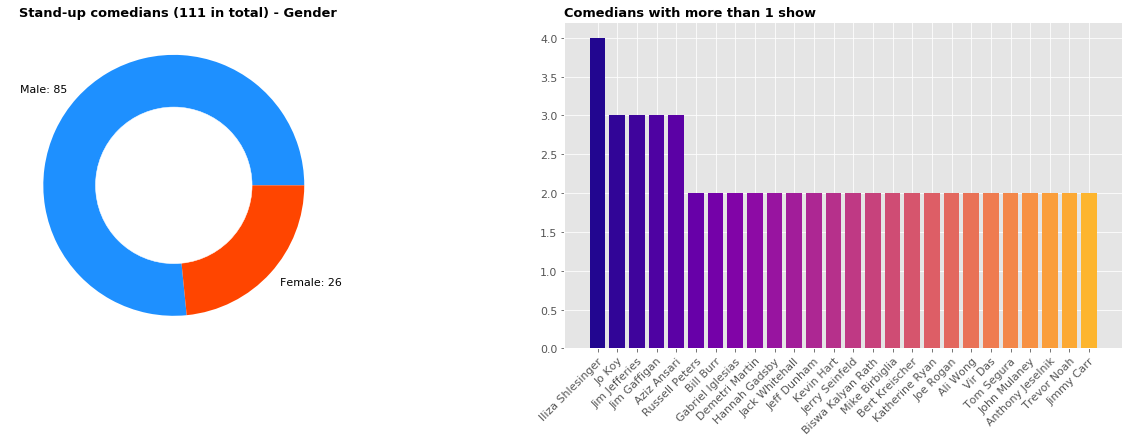

In [13]:
## General EDA charts panel (2) - Stand-up comedians

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 6))#set subplot and fig size

## AX1 - Number of comedians and gender

comedians = df.drop_duplicates(subset=['Comedian'], keep='first') # Retain unique comedian names
gender_num = list(comedians['Gender'].value_counts()) 
lbls = ['Male: {}'.format(gender_num[0]), 'Female: {}'.format(gender_num[1])]
colors = ['dodgerblue', 'orangered']

ax1.pie(gender_num, labels=lbls, colors=colors)
ax1.add_artist(plt.Circle((0, 0), 0.6, color='white')) # white circle at the centre
ax1.set_title('Stand-up comedians ({} in total) - Gender'.format(df['Comedian'].nunique()), fontweight='bold', fontsize=13, loc='right')


## AX2- Comedian with more than 1 show

com_shows_group = df.groupby('Comedian')['Title'].count().sort_values(ascending=False)
com_shows_num = com_shows_group[com_shows_group >= 2]
com_shows_lbl = com_shows_group[com_shows_group >= 2].index

ax2.bar(com_shows_lbl, com_shows_num, color=sns.color_palette("plasma", 30))
ax2.set_title('Comedians with more than 1 show', fontweight='bold', fontsize=13, loc='left')
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

## 2.2) NLP data exploration 

### 2.2.1) Fundamental text characteristics
The EDA on the fundamental characteristics of the stand-up comedy scripts reveals that:

- Looking at the text data, the vocabulary's size (i.e., the total number of unique words including stopwords) over the whole document corpus is 35747 words. The stand-up show scripts included in the sample have on average 9366 words with a distribution that ranges between 2985-13535 words. With respect to sentences, the average is 1067 and a distribution that ranges between 499-1856 sentences.

- Despite the unbalance with respect to comedian gender ratio and number of shows per comedian, the preliminary frequency analysis of tokens and sentences does not reveal sizeable differences in the overall script's lenght between male and female comedians. One observable difference is that male comedians tend to use more sentences per script (average number of sentences per script around 1100) compared to women (around 900 of sentences per script).

- Similarly, the breakdown of the distribution by producer does not highlight relevant differences between the Netflix and Amazon groups.

- In terms of content, the analysis of the most common "clean" tokens (i.e., tokenized text without stopwords) using Wordclouds does not reveal substantial differences in the most common words used by male and female commedians.

In [14]:
# Import libraries
from tqdm import tqdm
import spacy
import itertools
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

In [15]:
# Load spaCy pipeline with the default settings for English
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('sentencizer', before="ner") # Add sentencizer component to count sentences

# Correct some common word contractions to accomodate tokenizer
df['Text'] = df['Text'].str.replace('gonna', 'going to') # gonna => going to
df['Text'] = df['Text'].str.replace('gotta', 'have to') # gotta => have to
df['Text'] = df['Text'].str.replace("'re", " are") # 're => are

# Prepare list of documents to pass to spaCy pipeline
doc_list = list(df.iloc[:, 6])

print('Number of documents:', len(doc_list))
print('\nSpaCy English language model (small) - Pipeline components:', nlp.pipe_names)

Number of documents: 143

SpaCy English language model (small) - Pipeline components: ['tok2vec', 'tagger', 'parser', 'sentencizer', 'ner', 'attribute_ruler', 'lemmatizer']


In [16]:
# Loop to define:
token_num = [] # Token count per document
sent_num = [] # Sentence count per document
tokens_clean = [] # List of tokens per document (excluding punctuation, white spaces and stopwords)
tokens_stopw = [] # List of stop words per document 


# N.B. disable unnecessary spaCy pipeline components
for doc in tqdm(nlp.pipe(doc_list, disable=["tok2vec", "tagger", "parser", "ner", "attribute_ruler", "lemmatizer"], batch_size=30)): 
    
    # Tokenize text of each document (excluding punctuation) and separate stopwords
    word_tokens = [token.orth_ for token in doc if not token.is_punct | token.is_space | token.is_stop]
    word_stopw = [token.orth_ for token in doc if token.is_stop]
    tokens_clean.append(word_tokens)
    tokens_stopw.append(word_stopw)
    
    # Sentencize text of each document
    sentence_tokens = [sentence.text for sentence in doc.sents]
    
    # Append counts
    token_num.append(len(word_tokens)+len(word_stopw))
    sent_num.append(len(sentence_tokens))


# Add to dataframe
df['Token_count'] = pd.Series(token_num)
df['Sentence_count'] = pd.Series(sent_num)
df['Tokens_clean'] = pd.Series(tokens_clean)
df['Tokens_stopw'] = pd.Series(tokens_stopw)


# Vocabulary of the whole corpus of documents (i.e., list of unique tokens)
tokens_docs = list(set(list(itertools.chain(*tokens_clean))))
stopw_docs = list(set(list(itertools.chain(*tokens_stopw))))
vocab_docs = tokens_docs + stopw_docs

143it [00:14,  9.82it/s]


Total number of words (including stopwords) over the entire document corpus: 1339303 

Vocabulary size (i.e., number of unique tokens including stopwords) over the entire document corpus: 35746 

Average number of words per show (including stopwords): 9366 

Min-Max number of words per show (including stopwords): 2985 - 13535 



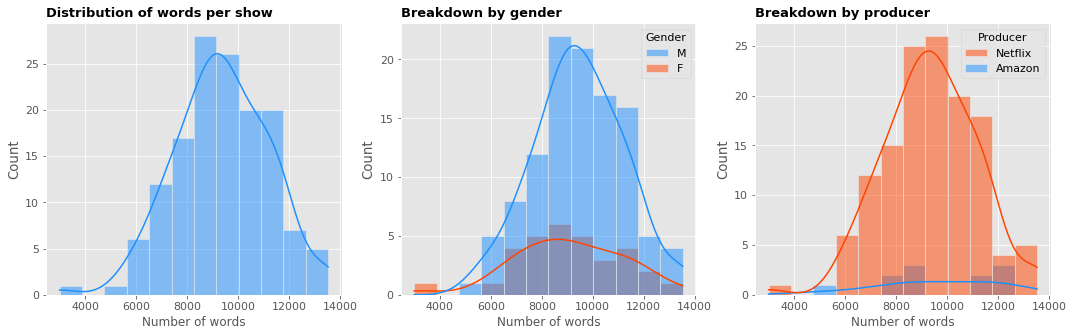

In [17]:
## Histograms text lenght (word count per show)

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5)) #set subplot and fig size

# Define number of words per document
words_num = df['Token_count']

print('\033[1m' + 'Total number of words (including stopwords) over the entire document corpus:' + '\033[0m', words_num.sum(), '\n\n'
      '\033[1m' + 'Vocabulary size (i.e., number of unique tokens including stopwords) over the entire document corpus:' + '\033[0m', len(vocab_docs), '\n\n'
      '\033[1m' + 'Average number of words per show (including stopwords):' + '\033[0m', round(words_num.mean()), '\n\n'
      '\033[1m' + 'Min-Max number of words per show (including stopwords):' + '\033[0m', round(words_num.min()), '-', round(words_num.max()), '\n')

# AX1 Histogram full sample

ax1 = sns.histplot(data=df, x=words_num, color='dodgerblue', ax=ax1, kde=True)
ax1.set_title('Distribution of words per show', fontweight='bold', fontsize=13, loc='left')
ax1.set_xlabel('Number of words', fontsize=12)

# AX2 Histogram split by gender

ax2 = sns.histplot(data=df, x=words_num, hue='Gender', palette=['dodgerblue', 'orangered'], ax=ax2, kde=True)
ax2.set_title('Breakdown by gender', fontweight='bold', fontsize=13, loc='left')
ax2.set_xlabel('Number of words', fontsize=12)

# AX3 Histogram split by producer

ax3 = sns.histplot(data=df, x=words_num, hue='Producer', palette=['orangered', 'dodgerblue'], ax=ax3, kde=True)
ax3.set_title('Breakdown by producer', fontweight='bold', fontsize=13, loc='left')
ax3.set_xlabel('Number of words', fontsize=12)

plt.show()

Total number of sentences over the whole document corpus: 152636 

Average number of sentences per show: 1067 

Minimum-Maximum number of sentences: 499 - 1856 



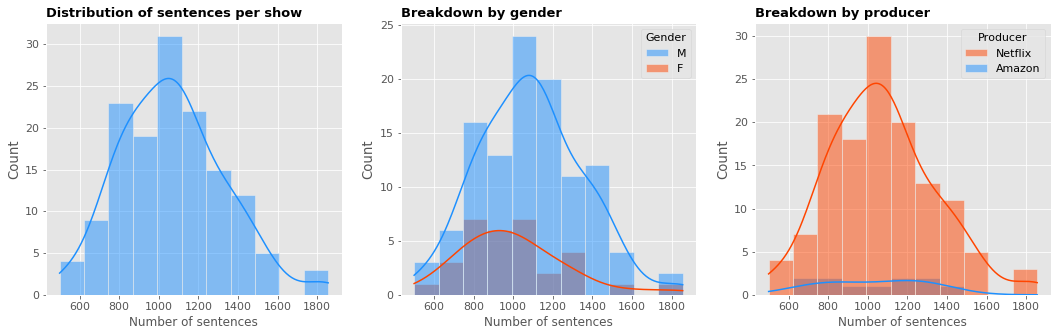

In [18]:
## Histograms sentence lenght (sentence count per show)

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5)) #set subplot and fig size

# Define number of sentences per show
sentences_num = df['Sentence_count']

print('\033[1m' + 'Total number of sentences over the whole document corpus:' + '\033[0m', round(sentences_num.sum()), '\n\n'
      '\033[1m' + 'Average number of sentences per show:' + '\033[0m', round(sentences_num.mean()), '\n\n'
      '\033[1m' + 'Minimum-Maximum number of sentences:' + '\033[0m', round(sentences_num.min()), '-', round(sentences_num.max()), '\n')

# AX1 Histogram full sample

ax1 = sns.histplot(data=df, x=sentences_num, color='dodgerblue', ax=ax1, kde=True)
ax1.set_title('Distribution of sentences per show', fontweight='bold', fontsize=13, loc='left')
ax1.set_xlabel('Number of sentences', fontsize=12)

# AX2 Histogram split by gender

ax2 = sns.histplot(data=df, x=sentences_num, hue='Gender', palette=['dodgerblue', 'orangered'], ax=ax2, kde=True)
ax2.set_title('Breakdown by gender', fontweight='bold', fontsize=13, loc='left')
ax2.set_xlabel('Number of sentences', fontsize=12)

# AX3 Histogram split by producer

ax3 = sns.histplot(data=df, x=sentences_num, hue='Producer', palette=['orangered', 'dodgerblue'], ax=ax3, kde=True)
ax3.set_title('Breakdown by producer', fontweight='bold', fontsize=13, loc='left')
ax3.set_xlabel('Number of sentences', fontsize=12)

plt.show()

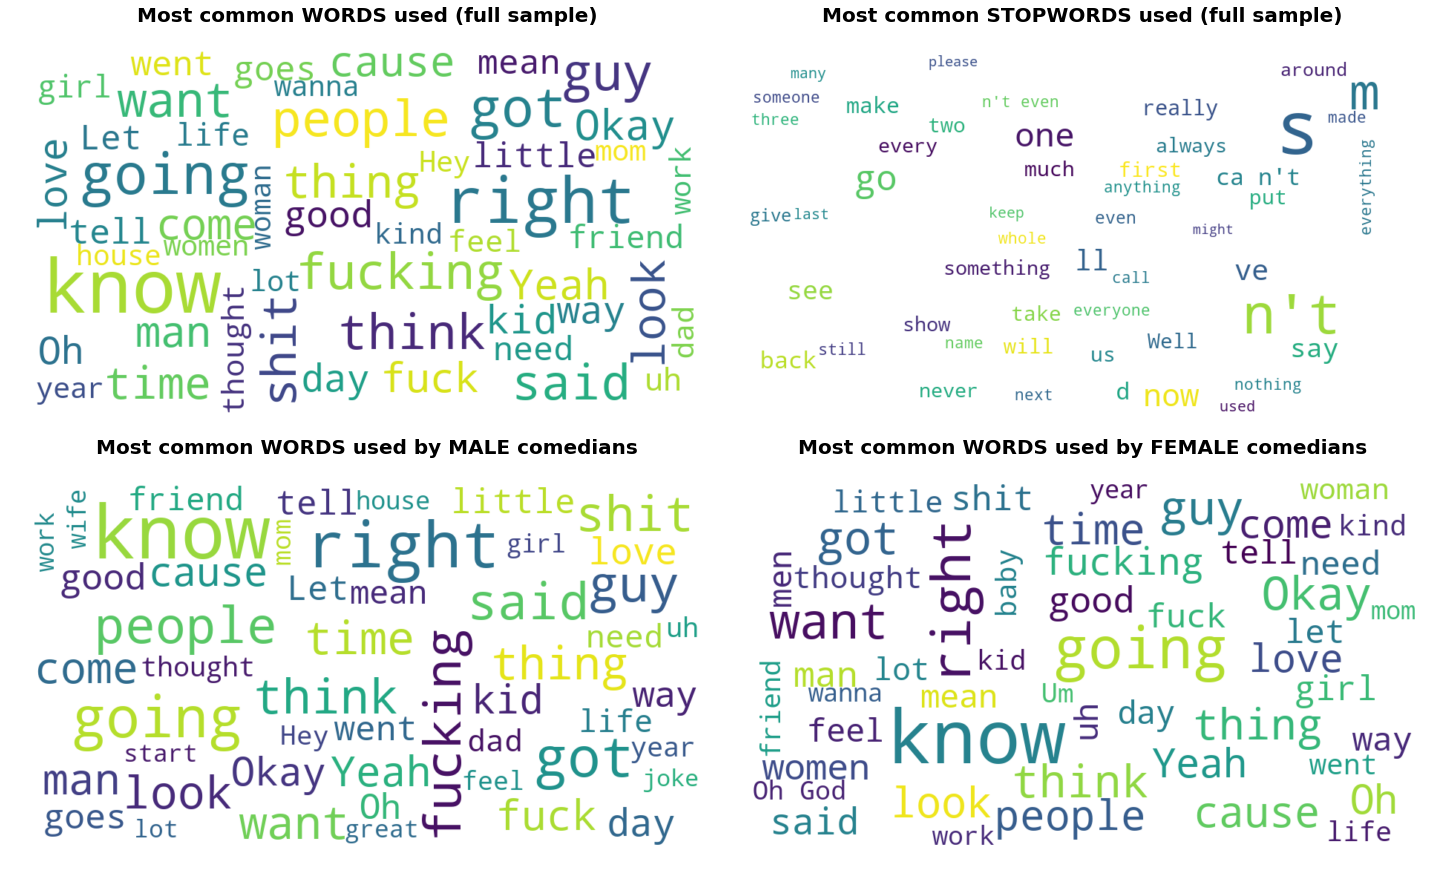

In [19]:
## Word Clouds clean tokens and stopwords

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 10 # set default font size

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))#set subplot and fig size

# AX1

# Merge list of lists in a unique list of tokens
tokens_clean_list = list(itertools.chain(*df['Tokens_clean']))
tokens_clean_list = " ".join(tokens for tokens in tokens_clean_list)

# Word Cloud
wordcloud_1 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(tokens_clean_list)

ax[0,0].imshow(wordcloud_1, interpolation='bilinear')
ax[0,0].axis("off")
ax[0,0].set_title('Most common WORDS used (full sample)\n', fontweight='bold', fontsize=20)


# AX2

# Merge list of lists in a unique list
tokens_stopw_list = list(itertools.chain(*df['Tokens_stopw']))
tokens_stopw_list = " ".join(tokens for tokens in tokens_stopw_list)

# Word Cloud
wordcloud_4 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(tokens_stopw_list)

ax[0,1].imshow(wordcloud_4, interpolation='bilinear')
ax[0,1].axis("off")
ax[0,1].set_title('Most common STOPWORDS used (full sample)\n', fontweight='bold', fontsize=20)

# AX3

# Merge list of lists in a unique list of tokens
tokens_clean_M = list(itertools.chain(*df[df['Gender']=='M']['Tokens_clean']))
tokens_clean_M = " ".join(tokens for tokens in tokens_clean_M)

# Word Cloud
wordcloud_2 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(tokens_clean_M)

ax[1,0].imshow(wordcloud_2, interpolation='bilinear')
ax[1,0].axis("off")
ax[1,0].set_title('Most common WORDS used by MALE comedians\n', fontweight='bold', fontsize=20)

# AX4

# Merge list of lists in a unique list of tokens
tokens_clean_F = list(itertools.chain(*df[df['Gender']=='F']['Tokens_clean']))
tokens_clean_F = " ".join(tokens for tokens in tokens_clean_F)

# Word Cloud
wordcloud_3 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(tokens_clean_F)

ax[1,1].imshow(wordcloud_3, interpolation='bilinear')
ax[1,1].axis("off")
ax[1,1].set_title('Most common WORDS used by FEMALE comedians\n', fontweight='bold', fontsize=20)

plt.tight_layout(pad=0)
plt.show()

### 2.2.2) Advanced EDA of text data

In this sub-section, I will exploit more advanced components of the SpaCy preprocessing pipeline such as the Part-Of-Speech (POS) tagger, the dependency parser and the lemmatizer. These tools allow to refine the cleaning of the tokens and help in getting some hints on the content of the stand-up shows.

I will first check the frequency of noun-chunks which are defined as "base noun phrases", i.e. noun plus neighbor words describing it such as adjectives+noun or article+noun. In this case, I will consider only noun-chunks that are made of at at least 2 words in order to obtain meaningful results. Afterwards, I will use POS tagger and lemmatizer to filter tokens and have a closer look at the most common proper nouns, nouns and adjectives used in stand-up comedy.

The main takeaways from the analysis are:
- Both the frequency analysis of noun-chunks and the WordCloud of tokens tagged as nouns by POS tagging reveal many references to general people (e.g., kid, guys, girl, women, men), family related nouns (e.g., mom, dad, wife, baby, child, friend) and other words such as "life" and "love". These elements suggest that personal stories, daily-life experiences & anecdotes are probably one of the most common topics discussed in stand-up comedy.

- In addition, the Wordcloud of the proper nouns identified with POS tagging suggests the presence of other potential topics such as satire on politics (e.g., Bill Clinton, Donald Trump, White House, United States), celebrities (e.g., Michael Jackson), religion (e.g., God, Jesus, Christ), national (e.g., American, Mexican, Indian) and racial (e.g., nigga) groups. However, it must be noted that words such as "God" and "Jesus" are also very common English exclamations which could be the main reason behind their high frequency in the corpus.

In [20]:
# Detailed summary of spaCy pipeline components and attributes
pipe_analysis = nlp.analyze_pipes(pretty=True)


============================= Pipeline Overview =============================

#   Component         Assigns               Requires   Scores             Retokenizes
-   ---------------   -------------------   --------   ----------------   -----------
0   tok2vec           doc.tensor                                          False      
                                                                                     
1   tagger            token.tag                        tag_acc            False      
                                                                                     
2   parser            token.dep                        dep_uas            False      
                      token.head                       dep_las                       
                      token.is_sent_start              dep_las_per_type              
                      doc.sents                        sents_p                       
                                                       sents

In [21]:
# Loop to define:

pos_propn = [] # List of lemmatized tokens with POS=proper noun 
pos_noun = [] # List of lemmatized tokens with POS=noun          
pos_adj = [] # List of lemmatized tokens with POS=adjective
noun_chuncks = [] # List of noun chunks per document (i.e., flat phrases that have a noun as their head)


# N.B. disable unnecessary spaCy pipeline components
for doc in tqdm(nlp.pipe(doc_list, disable=["ner", "sentencizer"], batch_size=3)):
    
    # Extract lemma of proper nouns 
    propn = [token.lemma_ for token in doc if token.pos_=='PROPN']
    pos_propn.append(propn)
    
    # Extract lemma of nouns 
    nouns = [token.lemma_ for token in doc if token.pos_=='NOUN']
    pos_noun.append(nouns)
    
    # Extract lemma of adjectives 
    adj = [token.lemma_ for token in doc if token.pos_=='ADJ']
    pos_adj.append(adj)
       
    # Extract noun-chunks made of at least 2 tokens
    chuncks = [chunck.text for chunck in doc.noun_chunks if len(chunck) > 1]
    noun_chuncks.append(chuncks)

# Add to dataframe

df['POS_propn'] = pd.Series(pos_propn)
df['POS_noun'] = pd.Series(pos_noun)
df['POS_adj'] = pd.Series(pos_adj)
df['Noun_chunk'] = pd.Series(noun_chuncks)

143it [03:34,  1.50s/it]


In [22]:
# Merge noun-chunks lists in a unique list of noun chuncks, lowercase strings and count them
chuncks_unique = list(itertools.chain(*df['Noun_chunk']))
noun_chuncks_full = Counter([x.lower() for x in chuncks_unique])
chuncks_all = pd.DataFrame.from_dict(noun_chuncks_full, orient='index').rename(columns={0: "Num_chuncks"})

chuncks_all.sort_values('Num_chuncks', ascending=False).head()

,Num_chuncks
a lot,911
you guys,665
the fuck,663
the world,505
my wife,495


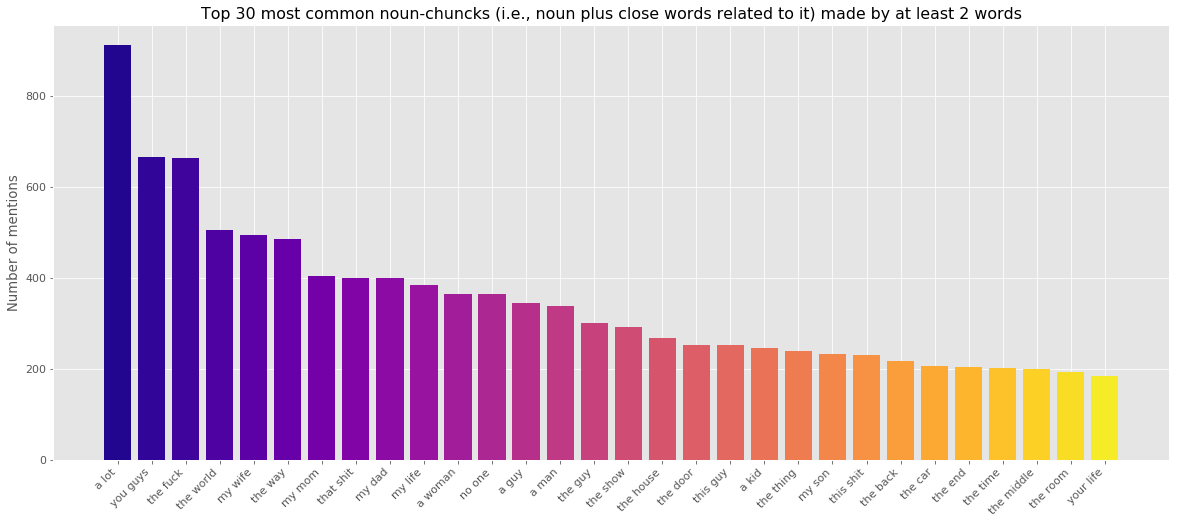

In [23]:
## Noun chuncks bar chart

# Plot
plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig = plt.figure(figsize=(20, 8))#set subplot and fig size

plt.bar(np.arange(30), chuncks_all.sort_values('Num_chuncks', ascending=False).head(30)['Num_chuncks'], color=sns.color_palette("plasma", 30))
plt.xticks(np.arange(30), chuncks_all.sort_values('Num_chuncks', ascending=False).head(30).index, rotation=45, ha="right")
plt.ylabel('Number of mentions')
plt.title('Top 30 most common noun-chuncks (i.e., noun plus close words related to it) made by at least 2 words')

plt.show()

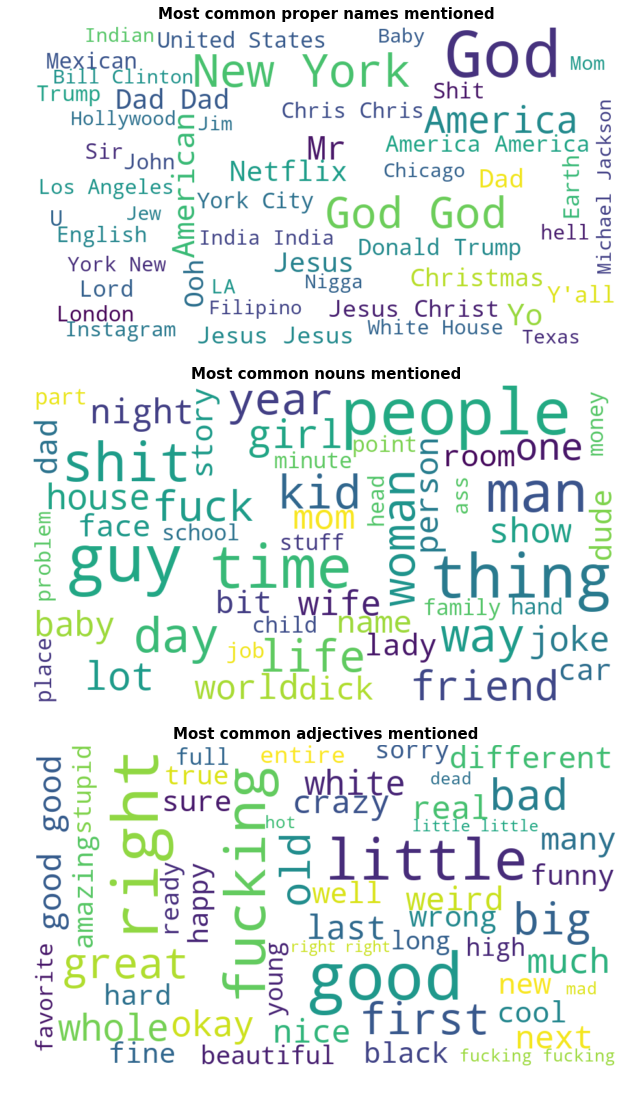

In [24]:
## Word Clouds tokens with on POS== PROPN, NOUN and ADJ

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 10 # set default font size

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))#set subplot and fig size

# AX1 PROPN

# Merge list of lists in a unique list of tokens
PROPN_clean_list = list(itertools.chain(*df['POS_propn']))
PROPN_clean_list = " ".join(tokens for tokens in PROPN_clean_list)

# Word Cloud
wordcloud_1 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(PROPN_clean_list)

ax[0].imshow(wordcloud_1, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('Most common proper names mentioned', fontweight='bold', fontsize=15)


# AX2

# Merge list of lists in a unique list of tokens
NOUN_clean_list = list(itertools.chain(*df['POS_noun']))
NOUN_clean_list = " ".join(tokens for tokens in NOUN_clean_list)

# Word Cloud
wordcloud_2 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(NOUN_clean_list)

ax[1].imshow(wordcloud_2, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title('Most common nouns mentioned', fontweight='bold', fontsize=15)

# AX3

# Merge list of lists in a unique list of tokens
ADJ_clean_list = list(itertools.chain(*df['POS_adj']))
ADJ_clean_list = " ".join(tokens for tokens in ADJ_clean_list)

# Word Cloud
wordcloud_3 = WordCloud(max_font_size=100, max_words=50, width=900, height=500, stopwords=None, background_color="white").generate(ADJ_clean_list)

ax[2].imshow(wordcloud_3, interpolation='bilinear')
ax[2].axis("off")
ax[2].set_title('Most common adjectives mentioned', fontweight='bold', fontsize=15)

plt.tight_layout(pad=0)
plt.show()